In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Install necessary libraries (if not pre-installed in Kaggle)
!pip install faiss-cpu sentence-transformers transformers --quiet

# Imports
import os
import faiss
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
from typing import List

# 1️⃣ Load and chunk data
def load_data(file_path: str) -> str:
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

def chunk_text(text: str, chunk_size: int = 500) -> List[str]:
    words = text.split()
    return [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]

# 2️⃣ Generate embeddings
def embed_chunks(chunks: List[str], model_name="sentence-transformers/all-MiniLM-L6-v2") -> np.ndarray:
    embedder = SentenceTransformer(model_name)
    embeddings = embedder.encode(chunks, convert_to_numpy=True)
    return embeddings, embedder

# Build FAISS index
def build_faiss_index(embeddings: np.ndarray) -> faiss.IndexFlatL2:
    dim = embeddings.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(embeddings)
    return index

#  Retrieval function
def retrieve(query: str, chunks: List[str], index: faiss.IndexFlatL2, embedder: SentenceTransformer, top_k: int = 3) -> str:
    query_embedding = embedder.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, top_k)
    return '\n'.join([chunks[i] for i in indices[0]])

#  Response generation with TinyLlama
def generate_response(context: str, query: str, model, tokenizer, max_length=256) -> str:
    prompt = f"<|system|>\nYou are a helpful assistant for menstrual health.\n<|user|>\n{query}\n<|assistant|>"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True)
    outputs = model.generate(**inputs, max_new_tokens=max_length)
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return result.split("<|assistant|>")[-1].strip()

#  Complete chatbot function
def rag_chatbot(file_path: str):
    print(" Loading data...")
    raw_text = load_data(file_path)
    chunks = chunk_text(raw_text)

    print(" Generating embeddings...")
    embeddings, embedder = embed_chunks(chunks)

    print(" Building FAISS index...")
    index = build_faiss_index(embeddings)

    print(" Loading TinyLlama model...")
    model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    print(" Chatbot is ready! Type 'exit' to stop.")

    while True:
        query = input("\nYou: ")
        if query.lower() in ['exit', 'quit']:
            print(" Exiting chatbot.")
            break
        context = retrieve(query, chunks, index, embedder)
        response = generate_response(context, query, model, tokenizer)
        print(f"\nChatbot: {response}")

#  Run chatbot with your uploaded dataset
file_path = '/kaggle/input/menstural-data-1/mens_data1.txt'
rag_chatbot(file_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 57.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.7 MB/s eta 0:00:00:00:0100:01


2025-07-24 04:44:49.723315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753332289.948786      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753332290.011503      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


 Loading data...
 Generating embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 Building FAISS index...
 Loading TinyLlama model...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

 Chatbot is ready! Type 'exit' to stop.



You:  what should i eat on my periods?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Chatbot: There are several foods that can help support menstrual health during your periods. Here are some suggestions:

1. Fresh fruits and vegetables: Fruits and vegetables are rich in vitamins, minerals, and fiber that can help support your body's natural menstrual cycle. Some examples include berries, leafy greens, citrus fruits, and sweet potatoes.

2. Whole grains: Whole grains, such as brown rice, quinoa, and whole wheat bread, are high in fiber, which can help regulate your menstrual cycle.

3. Lean proteins: Lean proteins, such as chicken, fish, and lean beef, are also good sources of protein that can help support your body's natural menstrual cycle.

4. Healthy fats: Healthy fats, such as omega-3 fatty acids found in fatty fish, nuts, and seeds, can help support your menstrual health.

5. Low-fat dairy: Low-fat dairy products, such as milk, yogurt, and che



You:  usually how long does periods last?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Chatbot: Periods typically last for 28-35 days, depending on the age and health of the woman. The length of the menstrual cycle can vary from woman to woman, and it can be shorter or longer than the average.



You:  how should my period cycle last for?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Chatbot: The length of your menstrual cycle can vary from woman to woman, but generally, it lasts for about 28 days. The length of your cycle can be shorter or longer, depending on your age, weight, and other factors. It's best to consult with a healthcare professional or a certified healthcare provider to determine your cycle length and any potential concerns.



You:  what is world health day?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Chatbot: World Health Day is an annual event held on April 7th to raise awareness about global health issues and to promote action towards improving the health and well-being of people worldwide. The theme for World Health Day 2021 is "Healthy lives and well-being for all: achieving the Sustainable Development Goals." The event aims to promote healthy behaviors, prevent diseases, and improve access to healthcare services for all.



You:  what is average period cycle for a woman of age, 28?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Chatbot: The average period cycle for a woman of age, 28, is approximately 28 days. This may vary slightly depending on factors such as age, weight, and hormonal changes.



You:  what is the solution for stomach pain?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Chatbot: Stomach pain is a common symptom of menstrual cramps. Here are some natural remedies that can help alleviate the pain:

1. Eat a balanced diet: Avoid eating spicy or fatty foods, as they can aggravate the pain. Eat a diet rich in fruits, vegetables, whole grains, and lean proteins.

2. Drink plenty of water: Drinking water can help flush out excess fluid and reduce the pain.

3. Take a warm bath: Soak in a warm bath with Epsom salt or baking soda. This can help relax the muscles and ease the pain.

4. Take a warm compress: Wrap a warm cloth in a towel and place it on your lower back or stomach. This can help reduce the pain and promote relaxation.

5. Take a relaxation break: Take a few deep breaths and focus on your breathing. This can help calm your mind and reduce stress.

6. Use a menstrual cup: A menstrual cup can help reduce the pain and discomfort of menstruation.


In [ ]:
model.save_pretrained("/kaggle/working/tinyllama_model")
tokenizer.save_pretrained("/kaggle/working/tinyllama_model")


In [2]:
# Install necessary libraries (if not pre-installed in Kaggle)
!pip install faiss-cpu sentence-transformers transformers --quiet

# Imports
import os
import faiss
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
from typing import List

# 1️⃣ Load and chunk data
def load_data(file_path: str) -> str:
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

def chunk_text(text: str, chunk_size: int = 500) -> List[str]:
    words = text.split()
    return [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]

# 2️⃣ Generate embeddings
def embed_chunks(chunks: List[str], model_name="sentence-transformers/all-MiniLM-L6-v2") -> np.ndarray:
    embedder = SentenceTransformer(model_name)
    embeddings = embedder.encode(chunks, convert_to_numpy=True)
    return embeddings, embedder

# Build FAISS index
def build_faiss_index(embeddings: np.ndarray) -> faiss.IndexFlatL2:
    dim = embeddings.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(embeddings)
    return index

#  Retrieval function
def retrieve(query: str, chunks: List[str], index: faiss.IndexFlatL2, embedder: SentenceTransformer, top_k: int = 3) -> str:
    query_embedding = embedder.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, top_k)
    return '\n'.join([chunks[i] for i in indices[0]])

#  Response generation with TinyLlama
def generate_response(context: str, query: str, model, tokenizer, max_length=256) -> str:
    prompt = f"<|system|>\nYou are a helpful assistant for menstrual health.\n<|user|>\n{query}\n<|assistant|>"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True)
    outputs = model.generate(**inputs, max_new_tokens=max_length)
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return result.split("<|assistant|>")[-1].strip()

#  Complete chatbot function
def rag_chatbot(file_path: str):
    print(" Loading data...")
    raw_text = load_data(file_path)
    chunks = chunk_text(raw_text)

    print(" Generating embeddings...")
    embeddings, embedder = embed_chunks(chunks)

    print(" Building FAISS index...")
    index = build_faiss_index(embeddings)

    print(" Loading TinyLlama model...")
    model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    print(" Chatbot is ready! Type 'exit' to stop.")
    while True:
        query = input("\nYou: ")
        if query.lower() in ['exit', 'quit']:
            print(" Exiting chatbot.")
            break
        context = retrieve(query, chunks, index, embedder)
        response = generate_response(context, query, model, tokenizer)
        print(f"\nChatbot: {response}")

#  Run chatbot with your uploaded dataset
file_path = '/kaggle/input/menstural-data-1/mens_data1.txt'
rag_chatbot(file_path)





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 37.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.7 MB/s eta 0:00:0000:0100:01


2025-08-28 06:46:01.668483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756363561.865716      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756363561.925404      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


 Loading data...
 Generating embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 Building FAISS index...
 Loading TinyLlama model...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

 Chatbot is ready! Type 'exit' to stop.



You:  how long do periods usually last?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Chatbot: Periods usually last for 28-35 days, depending on the age and health of the woman. The length of the menstrual cycle can vary from woman to woman, and it can be shorter or longer than the average period.



You:  what can a vegetarial eat during periods?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Chatbot: During periods, vegetarians can eat a variety of foods that are low in protein and high in fiber. Some vegetarian options for menstrual health include:

1. Leafy greens: Spinach, kale, and collard greens are all high in fiber and vitamins.

2. Legumes: Beans, lentils, and chickpeas are all excellent sources of protein and fiber.

3. Nuts and seeds: Almonds, cashews, and pumpkin seeds are all high in healthy fats and protein.

4. Fruits: Apples, bananas, and berries are all low in protein and high in fiber.

5. Vegetables: Carrots, sweet potatoes, and broccoli are all high in fiber and vitamins.

6. Whole grains: Whole grains like quinoa, brown rice, and whole wheat bread are all high in fiber and nutrients.

7. Nut butters: Peanut butter, almond butter, and cashew butter are all



You:  exit


 Exiting chatbot.


here goes the rag base model with FAISS embeddings

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_metric
import numpy as np

# Example test data (replace with your own)
test_queries = ["What are menstrual cramps?", "How to track menstrual cycle?"]
ground_truths = ["Menstrual cramps are pain during menstruation.", 
                 "You can track menstrual cycles using a calendar or app."]

# Function to evaluate retrieval (Recall@k, Precision@k, MRR)
def evaluate_retrieval(index, chunks, embedder, queries, ground_truths, k=3):
    recall, precision, rr = [], [], []
    for query, truth in zip(queries, ground_truths):
        query_emb = embedder.encode([query], convert_to_numpy=True)
        distances, indices = index.search(query_emb, k)
        retrieved = [chunks[i] for i in indices[0]]

        # Binary relevance
        relevant = [1 if truth in r else 0 for r in retrieved]
        rel_count = sum(relevant)

        recall.append(rel_count / 1)  # one ground truth per query
        precision.append(rel_count / k)
        rr.append(1 / (relevant.index(1) + 1) if 1 in relevant else 0)

    return np.mean(recall), np.mean(precision), np.mean(rr)

# Function to evaluate generation (ROUGE + Cosine Similarity)
def evaluate_generation(model, tokenizer, queries, ground_truths, chunks):
    from rouge_score import rouge_scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge1_scores, rougeL_scores, sim_scores = [], [], []

    for query, truth in zip(queries, ground_truths):
        context = retrieve(query, chunks, index, embedder)
        response = generate_response(context, query, model, tokenizer)

        # ROUGE scores
        rouge_scores = scorer.score(truth, response)
        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

        # Cosine similarity
        truth_emb = embedder.encode([truth], convert_to_numpy=True)
        resp_emb = embedder.encode([response], convert_to_numpy=True)
        sim = cosine_similarity(truth_emb, resp_emb)[0][0]
        sim_scores.append(sim)

    return np.mean(rouge1_scores), np.mean(rougeL_scores), np.mean(sim_scores)

# Run evaluation
recall, precision, mrr = evaluate_retrieval(index, chunks, embedder, test_queries, ground_truths)
rouge1, rougeL, similarity = evaluate_generation(model, tokenizer, test_queries, ground_truths, chunks)

print(f"Retrieval -> Recall@3: {recall:.2f}, Precision@3: {precision:.2f}, MRR: {mrr:.2f}")
print(f"Generation -> ROUGE-1: {rouge1:.2f}, ROUGE-L: {rougeL:.2f}, Semantic Similarity: {similarity:.2f}")

# Plot results
metrics = ['Recall@3', 'Precision@3', 'MRR', 'ROUGE-1', 'ROUGE-L', 'Similarity']
scores = [recall, precision, mrr, rouge1, rougeL, similarity]

plt.figure(figsize=(8,5))
bars = plt.bar(metrics, scores, color='skyblue')
plt.ylim(0,1)
plt.title("RAG Chatbot Evaluation Metrics")
plt.ylabel("Score")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center')
plt.show()


ImportError: cannot import name 'load_metric' from 'datasets' (/usr/local/lib/python3.11/dist-packages/datasets/__init__.py)

In [5]:
# 🔹 Load your data and prepare retrieval/generation pipeline for evaluation
file_path = '/kaggle/input/menstural-data-1/mens_data1.txt'

# 1. Load data
raw_text = load_data(file_path)
chunks = chunk_text(raw_text)

# 2. Generate embeddings
embeddings, embedder = embed_chunks(chunks)

# 3. Build FAISS index
index = build_faiss_index(embeddings)

# 4. Load TinyLlama model and tokenizer
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

print("✅ Data, FAISS index, and model loaded for evaluation!")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Data, FAISS index, and model loaded for evaluation!


In [8]:
!pip install rouge-score --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieval -> Recall@3: 0.00, Precision@3: 0.00, MRR: 0.00
Generation -> ROUGE-1: 0.14, ROUGE-L: 0.11, Semantic Similarity: 0.81


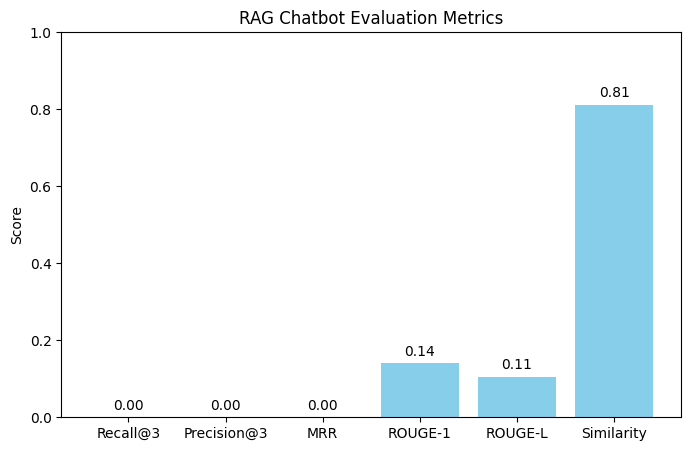

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Example test data (replace with your own)
test_queries = ["What are menstrual cramps?", "How to track menstrual cycle?"]
ground_truths = [
    "Menstrual cramps are pain during menstruation.",
    "You can track menstrual cycles using a calendar or app."
]

# Function to evaluate retrieval (Recall@k, Precision@k, MRR)
def evaluate_retrieval(index, chunks, embedder, queries, ground_truths, k=3):
    recall, precision, rr = [], [], []
    for query, truth in zip(queries, ground_truths):
        query_emb = embedder.encode([query], convert_to_numpy=True)
        distances, indices = index.search(query_emb, k)
        retrieved = [chunks[i] for i in indices[0]]

        # Binary relevance
        relevant = [1 if truth in r else 0 for r in retrieved]
        rel_count = sum(relevant)

        recall.append(rel_count / 1)  # one ground truth per query
        precision.append(rel_count / k)
        rr.append(1 / (relevant.index(1) + 1) if 1 in relevant else 0)

    return np.mean(recall), np.mean(precision), np.mean(rr)

# Function to evaluate generation (ROUGE + Cosine Similarity)
def evaluate_generation(model, tokenizer, queries, ground_truths, chunks, embedder, index):
    from rouge_score import rouge_scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge1_scores, rougeL_scores, sim_scores = [], [], []

    for query, truth in zip(queries, ground_truths):
        context = retrieve(query, chunks, index, embedder)
        response = generate_response(context, query, model, tokenizer)

        # ROUGE scores
        rouge_scores = scorer.score(truth, response)
        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

        # Cosine similarity
        truth_emb = embedder.encode([truth], convert_to_numpy=True)
        resp_emb = embedder.encode([response], convert_to_numpy=True)
        sim = cosine_similarity(truth_emb, resp_emb)[0][0]
        sim_scores.append(sim)

    return np.mean(rouge1_scores), np.mean(rougeL_scores), np.mean(sim_scores)

# Run evaluation
recall, precision, mrr = evaluate_retrieval(index, chunks, embedder, test_queries, ground_truths)
rouge1, rougeL, similarity = evaluate_generation(model, tokenizer, test_queries, ground_truths, chunks, embedder, index)

print(f"Retrieval -> Recall@3: {recall:.2f}, Precision@3: {precision:.2f}, MRR: {mrr:.2f}")
print(f"Generation -> ROUGE-1: {rouge1:.2f}, ROUGE-L: {rougeL:.2f}, Semantic Similarity: {similarity:.2f}")

# Plot results
metrics = ['Recall@3', 'Precision@3', 'MRR', 'ROUGE-1', 'ROUGE-L', 'Similarity']
scores = [recall, precision, mrr, rouge1, rougeL, similarity]

plt.figure(figsize=(8,5))
bars = plt.bar(metrics, scores, color='skyblue')
plt.ylim(0,1)
plt.title("RAG Chatbot Evaluation Metrics")
plt.ylabel("Score")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center')
plt.show()
